### PS8 Lerong Wang

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import itertools
import warnings
%matplotlib inline

### (a)

In [5]:
drink = pd.read_csv('strongdrink.txt')
drink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


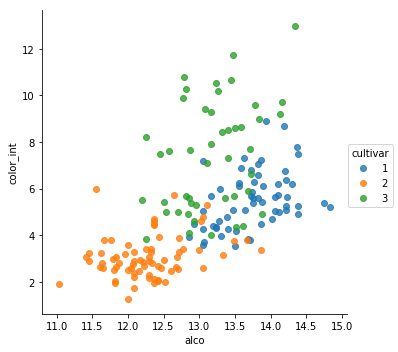

In [6]:
sns.lmplot('alco','color_int', drink, hue = 'cultivar', fit_reg = False)

### (b)

In [11]:
Xvals = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = drink['cultivar'].values

k = 4
clf_mlog = KFold(n_splits=k, random_state=22, shuffle=True)
clf_mlog.get_n_splits(Xvals)
MSE = np.zeros(k)
C = np.zeros(200)
MSE_C = np.zeros(200)

for index in range(200):
    k_ind = int(0)
    c = (index + 1)/100
    for train_index, test_index in clf_mlog.split(Xvals):
        X_train, X_test = Xvals[train_index], Xvals[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = c)
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[index] = c
    MSE_C[index] =  MSE.mean()
MSE_logit = pd.DataFrame({'C':C, 'MSE':MSE_C})
MSE_logit.sort_values(['MSE']).head(10)

,C,MSE
43,0.44,0.068182
44,0.45,0.068182
42,0.43,0.068182
41,0.42,0.068182
40,0.41,0.068182
39,0.40,0.068182
27,0.28,0.068182
28,0.29,0.068182
29,0.30,0.068182
30,0.31,0.068182


With C = 0.44, penalty is 'l2', lowest MSE = 0.068182.

### (c)

In [12]:
MSE_rf = pd.DataFrame({"n_estimator" : np.zeros(5), "min_sample" : np.zeros(5), "max_depth" : np.zeros(5),
                       "MSE" : np.zeros(5)})
MSE_df = MSE_rf[:0]

for i in range(15):
    for j in range(15):
        for tree in range(5):
            rf = RandomForestClassifier(n_estimators = (tree * 50 + 50),
                                        min_samples_leaf = (i * 5 + 5),
                                        max_depth = (j + 1), bootstrap=True, 
                                        oob_score=True, random_state=22)
            rf.fit(Xvals, yvals)
            MSE_rf["n_estimator"][tree] = tree * 50 + 50
            MSE_rf["max_depth"][tree] = j + 1
            MSE_rf["min_sample"][tree] = i * 5 + 5
            MSE_rf["MSE"][tree] = 1 - rf.oob_score_
        MSE_df= pd.concat([MSE_df, MSE_rf])
MSE_df.index = range(len(MSE_df))
MSE_df.sort_values(['MSE']).head(5)

,MSE,max_depth,min_sample,n_estimator
96,0.068182,5.0,10.0,100.0
126,0.068182,11.0,10.0,100.0
116,0.068182,9.0,10.0,100.0
131,0.068182,12.0,10.0,100.0
111,0.068182,8.0,10.0,100.0


With the max_depth = 5, min_sample_leaf = 10, n_estimator = 100, the lowest MSE of random forest classifier is 0.068182.

### (d)

In [13]:
k = 4
clf_svm = KFold(n_splits=k, random_state=22, shuffle=True)
clf_svm.get_n_splits(Xvals)
MSE = np.zeros(k)
MSE_C = pd.DataFrame({"Cost" : np.zeros(80),
                      "Gamma" : np.zeros(80),
                      "MSE" : np.zeros(80)})
MSE_SVM = MSE_C[:0]

for g in range(80):
    for c in range(80):
        k_ind = int(0)
        for train_index, test_index in clf_svm.split(Xvals):
            X_train, X_test = Xvals[train_index], Xvals[test_index]
            y_train, y_test = yvals[train_index], yvals[test_index]
            svc = SVC(kernel='rbf', gamma = (g/20 + 0.05),
                          C=c/20 + 0.05)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_C['Cost'][c] = c/20 + 0.05
        MSE_C['Gamma'][c] = g/20 + 0.05
        MSE_C['MSE'][c] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head(10)

,Cost,Gamma,MSE
2659,1.00,1.70,0.045455
2578,0.95,1.65,0.045455
2658,0.95,1.70,0.045455
224,3.25,0.15,0.051136
225,3.30,0.15,0.051136
226,3.35,0.15,0.051136
227,3.40,0.15,0.051136
228,3.45,0.15,0.051136
229,3.50,0.15,0.051136
218,2.95,0.15,0.051136


With cost=1, gamma=1.7, the lowest mse = 0.45455

### (e)

In [15]:
k = 4
clf_mlp = KFold(n_splits=k, random_state=22, shuffle=True)
clf_mlp.get_n_splits(Xvals)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({"activation" : np.zeros(20), "hidden layer" : np.zeros(20), "alpha" : np.zeros(20),
                       "MSE":np.zeros(20)})
MSE_mlp = MSE_al[:0]

for i in range(4):
    for j in range(8):
        for k in range(20):
            k_ind = int(0)
            for train_index, test_index in clf_mlp.split(Xvals):
                X_train, X_test = Xvals[train_index], Xvals[test_index]
                y_train, y_test = yvals[train_index], yvals[test_index]
                mlp = MLPClassifier(activation=activ[i], solver='lbfgs',
                                    alpha=(k/20 + 0.05), random_state=25,
                                    hidden_layer_sizes = ((50 * (j + 1)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1


            MSE_al['activation'][k] = activ[i]
            MSE_al['hidden layer'][k] = 50 * (j + 1)
            MSE_al['alpha'][k] = k/20 + 0.05
            MSE_al['MSE'][k] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,MSE,activation,alpha,hidden layer
548,0.034091,relu,0.45,200.0
585,0.039773,relu,0.30,300.0
553,0.039773,relu,0.70,200.0
562,0.039773,relu,0.15,250.0
584,0.039773,relu,0.25,300.0
617,0.045455,relu,0.90,350.0
523,0.045455,relu,0.20,150.0
613,0.045455,relu,0.70,350.0
492,0.045455,relu,0.65,50.0
525,0.045455,relu,0.30,150.0


With activation = relu, alpha = 0.45 and hidden layer = 200, lowest MSE is 0.034091.

### (f)

In [17]:
logit = np.array(MSE_logit.sort_values(['MSE']).head(10)['MSE'])
rf = np.array(MSE_df.sort_values(['MSE']).head(10)['MSE'])
svm = np.array(MSE_SVM.sort_values(['MSE']).head(10)['MSE'])
mlp = np.array(MSE_mlp.sort_values(['MSE']).head(10)['MSE'])
pd.DataFrame({'logit':logit, 'rf':rf,'svm':svm, 'mlp': mlp})


,logit,mlp,rf,svm
0,0.068182,0.034091,0.068182,0.045455
1,0.068182,0.039773,0.068182,0.045455
2,0.068182,0.039773,0.068182,0.045455
3,0.068182,0.039773,0.068182,0.051136
4,0.068182,0.039773,0.068182,0.051136
5,0.068182,0.045455,0.068182,0.051136
6,0.068182,0.045455,0.068182,0.051136
7,0.068182,0.045455,0.068182,0.051136
8,0.068182,0.045455,0.068182,0.051136
9,0.068182,0.045455,0.068182,0.051136


Comparing MSE values across different models, I think mlp is the best model